This notebook will experiment with interpolating Live Ocean results to our boundary. The goal is that eventually these routines will be translated into a script.

In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime

import glob

from salishsea_tools import viz_tools

%matplotlib inline

# Load our boundary

In [2]:
f = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_corrected.nc')
depBC = f.variables['deptht'][:]
lonBC = f.variables['nav_lon'][:]
latBC = f.variables['nav_lat'][:]
salBC = f.variables['vosaline'][:]
tempBC = f.variables['votemper'][:]
time = f.variables['time_counter'][:]
#fake the dates
start = datetime.datetime(2016,1,1)
dates = [start + datetime.timedelta(weeks=int(d)) for d in time]
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

# Load Live Ocean

Plan - Load about one month and then resample to weekly frequency for comparisons with our boundary conditions.

### Basic loading

In [3]:
base = '/ocean/nsoontie/MEOPAR/LiveOcean/*/*UBC.nc'
files = glob.glob(base)
files.sort()

d = xr.open_dataset(files[0])
for f in files[1:]:
    with xr.open_dataset(f) as d1:
        d =xr.concat([d,d1],dim='ocean_time',data_vars='minimal')

### Add depth array

In [4]:
import grid
#build depth
fname = '/ocean/nsoontie/MEOPAR/LiveOcean/20160601/ocean_his_0002_UBC.nc'
G, S, T = grid.get_basic_info(fname)
z_rho = np.zeros(d.salt.shape)
for t in np.arange(z_rho.shape[0]):
    zeta = d.zeta.values[t,:,:]
    z_rho[t,:,:,:] = grid.get_z(G['h'],zeta,S)

In [5]:
#build a x_rho data array
zrho_DA = xr.DataArray(z_rho, dims = ['ocean_time','s_rho', 'eta_rho', 'xi_rho'],
                       coords = {'ocean_time': d.ocean_time.values[:],
                                 's_rho': d.s_rho.values[:],
                                 'eta_rho': d.eta_rho.values[:],
                                 'xi_rho': d.xi_rho.values[:]},
                       attrs = {'units': 'metres',
                                'positive': 'up',
                                'long_name': 'Depth at s-levels',
                                'field': 'z_rho ,scalar'})
d = d.assign(z_rho = zrho_DA)

### Resample to Weekly

In [6]:
weekly = d.resample('7D', 'ocean_time')

In [7]:
weekly.ocean_time

<xarray.DataArray 'ocean_time' (ocean_time: 5)>
array(['2016-06-01T01:00:00.000000000', '2016-06-08T01:00:00.000000000',
       '2016-06-15T01:00:00.000000000', '2016-06-22T01:00:00.000000000',
       '2016-06-29T01:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2016-06-01T01:00:00 ...

# Interpolating

## Depths
First, interpolate onto our model level depths.

In [8]:
sal_interp = np.zeros(weekly.salt.shape)

In [9]:
for t in np.arange(sal_interp.shape[0]):
    for j in np.arange(sal_interp.shape[2]):
        for i in np.arange(sal_interp.shape[3]):
            depths = weekly.z_rho.values[t,:,j,i] 
            var = weekly.salt.values[t,:,j,i]
            sal_interp[t,:,j,i] = np.interp(-depBC,depths,var)


### Check this is reasonable by plotting
Slice along a longitude at a time

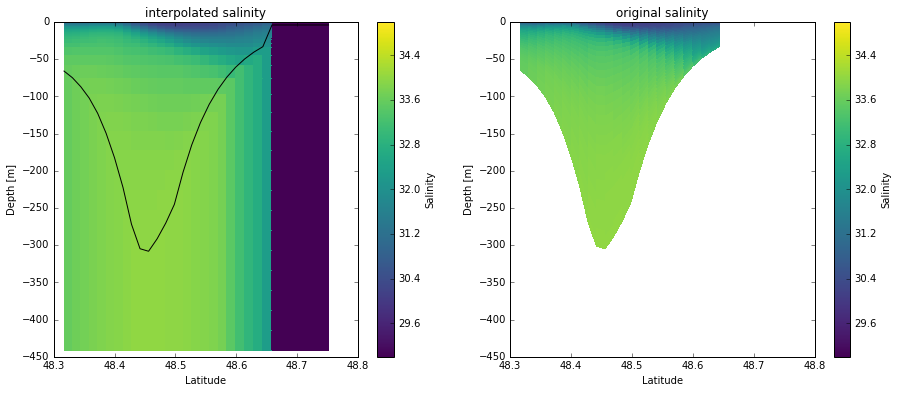

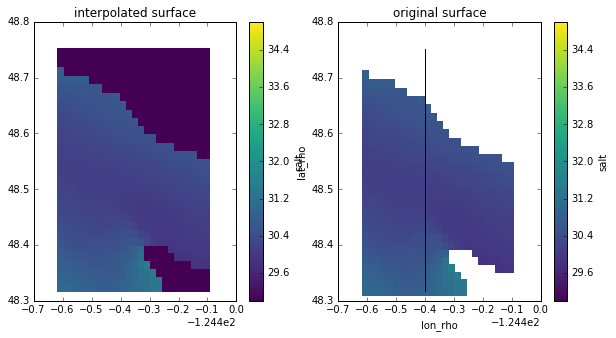

In [10]:
i=10
t=3
s=39; k=0
fig,axs = plt.subplots(1,2,figsize=(15,6))
#interpolated
ax=axs[0]
mesh = ax.pcolormesh(weekly.lat_rho.values[:,i], -depBC,sal_interp[t,:,:,i],vmin=29,vmax=35,cmap='viridis')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Salinity')
ax.set_title('interpolated salinity')
ax.plot(weekly.lat_rho.values[:,i],-G['h'][:,i],'k-')
#orginial
ax=axs[1]
plotting = weekly.isel(xi_rho=i,ocean_time=t)
dplot = plotting.z_rho.values[:]
latplot,_ = np.meshgrid(plotting.lat_rho.values[:], dplot[:,0])
mesh=ax.pcolormesh(latplot,dplot, plotting.salt.values[:],vmin=29,vmax=35, cmap='viridis')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Salinity')
ax.set_title('original salinity')
for ax in axs:
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Latitude')
    ax.set_xlim([48.3,48.8])
    ax.set_ylim([-450,0])
fig,axs=plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
mesh=ax.pcolormesh(weekly.lon_rho.values[:],weekly.lat_rho.values[:],sal_interp[t,k,:,:],
              vmin=29,vmax=35,cmap='viridis')
ax.set_title('interpolated surface')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('salt')
ax=axs[1]
weekly.isel(s_rho=s, ocean_time=t).salt.plot(x='lon_rho', y='lat_rho',ax=ax,
                                             vmin=29,vmax=35,cmap='viridis')
ax.plot(weekly.lon_rho.values[:,i], weekly.lat_rho.values[:,i],'k-')
ax.set_title('original surface')

It looks like we are setting 0 in land points (z_rho is nan there). This could be problematic for interpolating laterally. I should be sure to mask before interpolating laterally...

Another note: because I'm using numpy interp, I am filling points below the bathymetry with the closest sea point in that column.

#### Another quick check 
time series at a point

(40, 5) (5, 40)


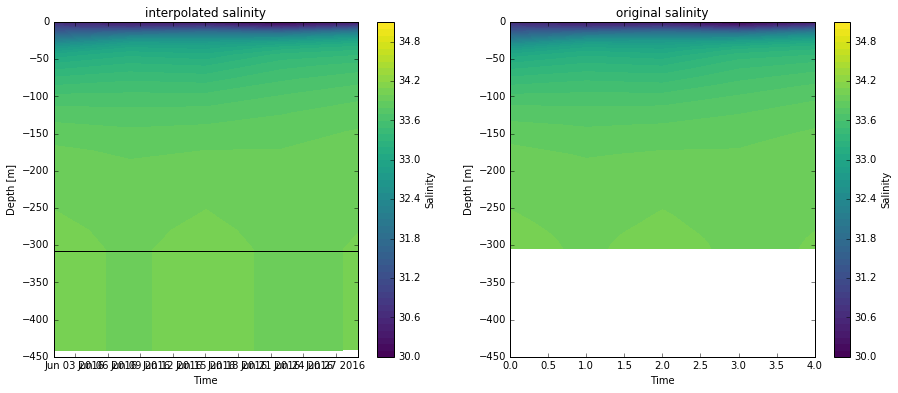

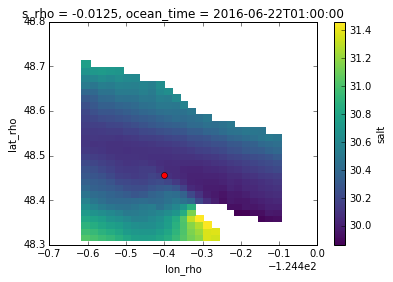

In [11]:
i=10
j=10
s=39
levels = np.arange(30,35.1,.1)
fig,axs = plt.subplots(1,2,figsize=(15,6))
#interpolated
ax=axs[0]
mesh = ax.contourf(weekly.ocean_time.values[:], -depBC, sal_interp[:,:,j,i].T,levels,cmap='viridis')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Salinity')
ax.set_title('interpolated salinity')
ax.plot(weekly.ocean_time.values,-G['h'][j,i]*np.ones(weekly.ocean_time.shape),'k-')
#orginal
ax=axs[1]
plotting = weekly.isel(xi_rho=i,eta_rho=j)
dplot = plotting.z_rho.values[:]
tplot,_ = np.meshgrid(np.arange(weekly.ocean_time.shape[0]), dplot[0,:])
print(tplot.shape, dplot.shape)
mesh=ax.contourf(tplot.T,dplot, plotting.salt.values[:],levels, cmap='viridis')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Salinity')
ax.set_title('original salinity')
for ax in axs:
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Time')
    ax.set_ylim([-450,0])
fig,ax=plt.subplots(1,1)
weekly.isel(s_rho=s, ocean_time=t).salt.plot(x='lon_rho', y='lat_rho',ax=ax)
ax.plot(weekly.lon_rho.values[j,i], weekly.lat_rho.values[j,i],'ro')

### Mask

Apply the Live Ocean horizontal mask to interpolated salinity

In [12]:
mask_rho = weekly.mask_rho.values[:] #extract mask
mask_rho = np.expand_dims(mask_rho,axis=1) + np.zeros(weekly.salt.shape) # expand along depth
npmask = 1-mask_rho #invert for numpy masking
sal_interp = np.ma.array(sal_interp,mask=npmask)

Check mask

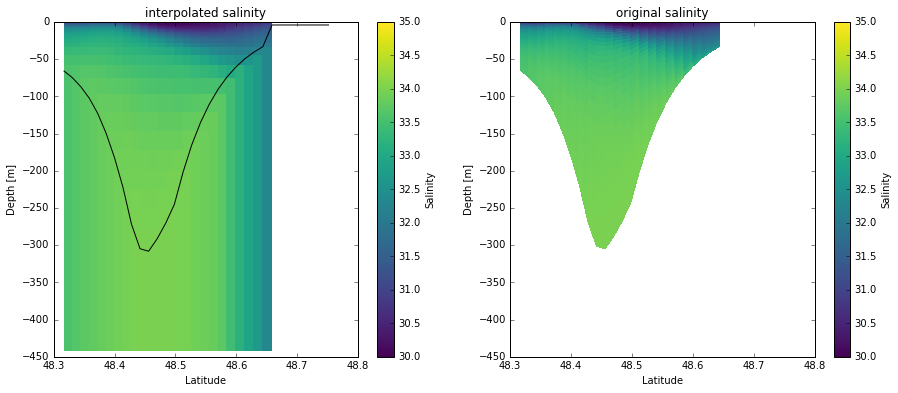

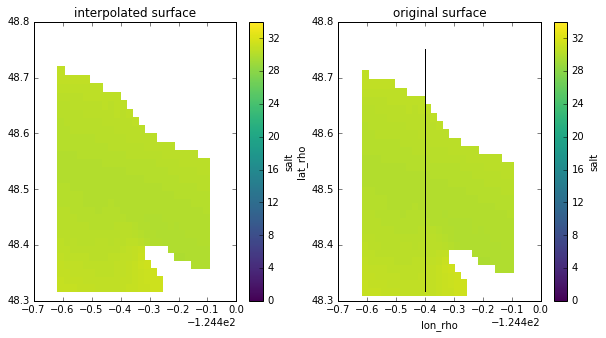

In [13]:
i=10
t=3
s=39
fig,axs = plt.subplots(1,2,figsize=(15,6))
#interpolated
ax=axs[0]
mesh = ax.pcolormesh(weekly.lat_rho.values[:,i], -depBC,sal_interp[t,:,:,i],vmin=30,vmax=35,cmap='viridis')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Salinity')
ax.set_title('interpolated salinity')
ax.plot(weekly.lat_rho.values[:,i],-G['h'][:,i],'k-')
#orginial
ax=axs[1]
plotting = weekly.isel(xi_rho=i,ocean_time=t)
dplot = plotting.z_rho.values[:]
latplot,_ = np.meshgrid(plotting.lat_rho.values[:], dplot[:,0])
mesh=ax.pcolormesh(latplot,dplot, plotting.salt.values[:],vmin=30,vmax=35, cmap='viridis')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Salinity')
ax.set_title('original salinity')
for ax in axs:
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Latitude')
    ax.set_xlim([48.3,48.8])
    ax.set_ylim([-450,0])
fig,axs=plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
mesh=ax.pcolormesh(weekly.lon_rho.values[:],weekly.lat_rho.values[:],sal_interp[t,k,:,:],
              vmin=0,vmax=34,cmap='viridis')
ax.set_title('interpolated surface')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('salt')
ax=axs[1]
weekly.isel(s_rho=s, ocean_time=t).salt.plot(x='lon_rho', y='lat_rho',ax=ax,
                                             vmin=0,vmax=34,cmap='viridis')
ax.plot(weekly.lon_rho.values[:,i], weekly.lat_rho.values[:,i],'k-')
ax.set_title('original surface')

## Interpolate laterally

In [14]:
from scipy import interpolate

In [15]:
#reshape our BC grid to use griddata
lat2 = latBC.reshape((10,87))
lon2 = lonBC.reshape((10,87))
#combine LiveOcean grid to use griddata
points = np.array([ d.lon_rho.values[:].flatten(),  d.lat_rho.values[:].flatten()])

In [16]:
sal_new = np.zeros((sal_interp.shape[0], sal_interp.shape[1], 1, salBC.shape[-1]))

for t in np.arange(sal_new.shape[0]):
    for k in np.arange(sal_new.shape[1]):
        sal_grid = sal_interp[t,k,:,:]
        fi = interpolate.interp2d(d.lat_rho.values[:].flatten(),
                                  d.lon_rho.values[:].flatten(), sal_grid)
        
        sal_interp_lateral = interpolate.griddata(points.T,sal_grid.flatten(), (lon2,lat2), )
        sal_new[t,k,0,:] = sal_interp_lateral.flatten()

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=30,31 m=806 fp=nan s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


Quick check at surface

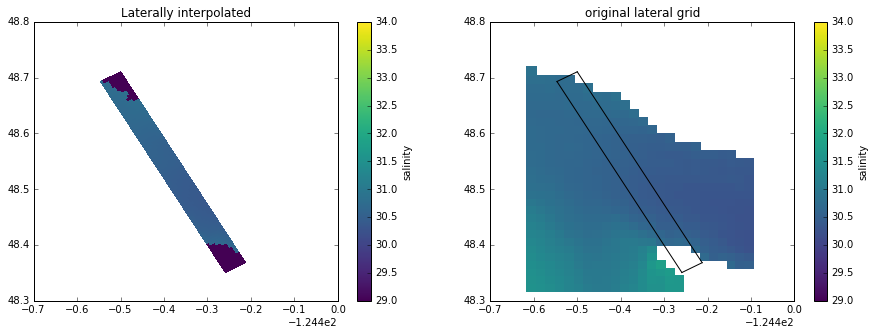

In [17]:
t=0
k=0

fig,axs = plt.subplots(1,2,figsize=(15,5))
#Lateral interp
ax=axs[0]
mesh=ax.pcolormesh(lon2,lat2,sal_new[t,k,:,:].reshape(10,87),vmin=29,vmax=34,cmap='viridis')
cbar = plt.colorbar(mesh,ax=ax)
cbar.set_label('salinity')
ax.set_title('Laterally interpolated')
#original lateral grid
ax=axs[1]
mesh=ax.pcolormesh(d.lon_rho.values[:], d.lat_rho.values[:], sal_interp[t,k,:,:], vmin=29, vmax=34,
                   cmap='viridis')
cbar=plt.colorbar(mesh,ax=ax)
ax.plot([lon2[0,0],lon2[-1,0]], [lat2[0,0],lat2[-1,0]], 'k-')
ax.plot([lon2[0,0],lon2[0,-1]], [lat2[0,0],lat2[0,-1]], 'k-')
ax.plot([lon2[-1,-1],lon2[-1,0]], [lat2[-1,-1],lat2[-1,0]], 'k-')
ax.plot([lon2[0,-1],lon2[-1,-1]], [lat2[0,-1],lat2[-1,-1]], 'k-')
cbar.set_label('salinity')
ax.set_title('original lateral grid')
#limits
for ax in axs:
    ax.set_xlim([-125.1,-124.4])
    ax.set_ylim([48.3,48.8])

"Land" points may be an issue for us. It looks like these are Nans in the interpolation. Should I fill them with nearest neighbour?

# Compare with our BCs

In [18]:
t1=0
t2=21
#check they are both first week of June
print(weekly.ocean_time.values[t1],dates[t2])

2016-06-01T01:00:00.000000000 2016-06-03 00:00:00


Surface

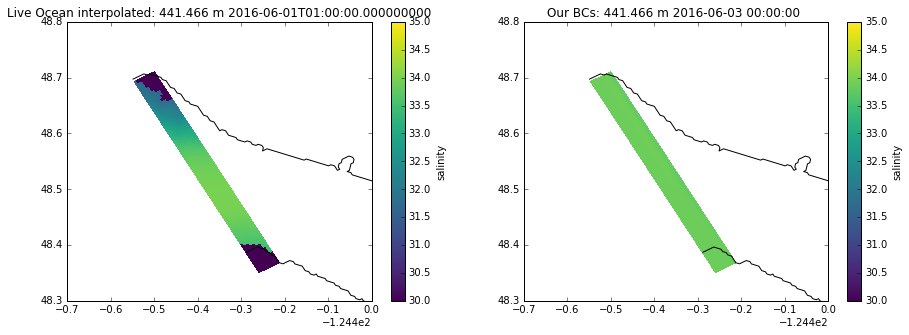

In [19]:
fig,axs = plt.subplots(1,2,figsize=(15,5))
vmin=30
vmax=35
k=39
#Live Ocean
t=t1
ax=axs[0]
mesh=ax.pcolormesh(lon2,lat2,sal_new[t,k,:,:].reshape(10,87),vmin=vmin,vmax=vmax,cmap='viridis')
cbar = plt.colorbar(mesh,ax=ax)
cbar.set_label('salinity')
ax.set_title('Live Ocean interpolated: {0:.3f} m {1}'.format(depBC[k], weekly.ocean_time.values[t]))
#Our BCs
t=t2
ax=axs[1]
mesh=ax.pcolormesh(lon2,lat2, salBC[t2,k,:,:].reshape(10,87), vmin=vmin, vmax=vmax,
                   cmap='viridis')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('salinity')
ax.set_title('Our BCs: {0:.3f} m {1} '.format(depBC[k], dates[t]))
#limits
for ax in axs:
    ax.set_xlim([-125.1,-124.4])
    ax.set_ylim([48.3,48.8])
    viz_tools.plot_coastline(ax,bathy,coords='map')

Yes, I will have to do something about the NaNs...

### Fill NaNs

In [20]:
def fill_NaNs_with_nearest_neighbour(boundary, lats, lons):
    filled = boundary.copy()
    for t in np.arange(boundary.shape[0]):
        for k in np.arange(boundary.shape[1]):
            subdata = boundary[t,k,:,:]
            mask = np.isnan(subdata)
            points = np.array([lons[~mask],lats[~mask]]).T
            data =subdata[~mask]
            filled[t,k,mask] = interpolate.griddata(points, data, (lons[mask], lats[mask]),method='nearest')
                                            
    return filled

In [21]:
filled = fill_NaNs_with_nearest_neighbour(sal_new, latBC, lonBC)

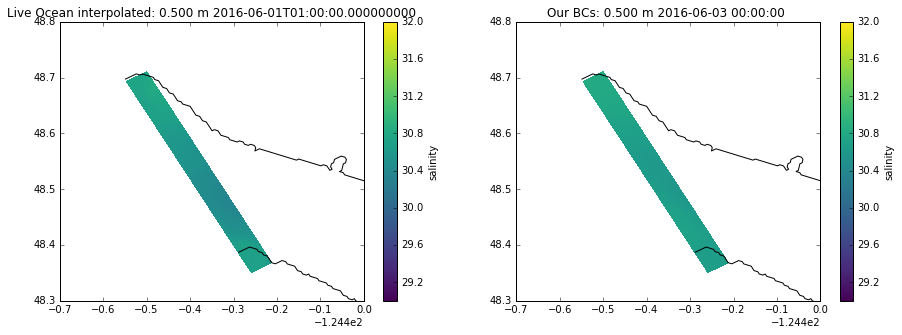

In [22]:
fig,axs = plt.subplots(1,2,figsize=(15,5))
vmin=29
vmax=32
k=0
#Live Ocean
t=t1
ax=axs[0]
mesh=ax.pcolormesh(lon2,lat2,filled[t,k,:,:].reshape(10,87),vmin=vmin,vmax=vmax,cmap='viridis')
cbar = plt.colorbar(mesh,ax=ax)
cbar.set_label('salinity')
ax.set_title('Live Ocean interpolated: {0:.3f} m {1}'.format(depBC[k], weekly.ocean_time.values[t]))
#Our BCs
t=t2
ax=axs[1]
mesh=ax.pcolormesh(lon2,lat2, salBC[t2,k,:,:].reshape(10,87), vmin=vmin, vmax=vmax,
                   cmap='viridis')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('salinity')
ax.set_title('Our BCs: {0:.3f} m {1} '.format(depBC[k], dates[t]))
#limits
for ax in axs:
    ax.set_xlim([-125.1,-124.4])
    ax.set_ylim([48.3,48.8])
    viz_tools.plot_coastline(ax,bathy,coords='map')

### Check a time slice 

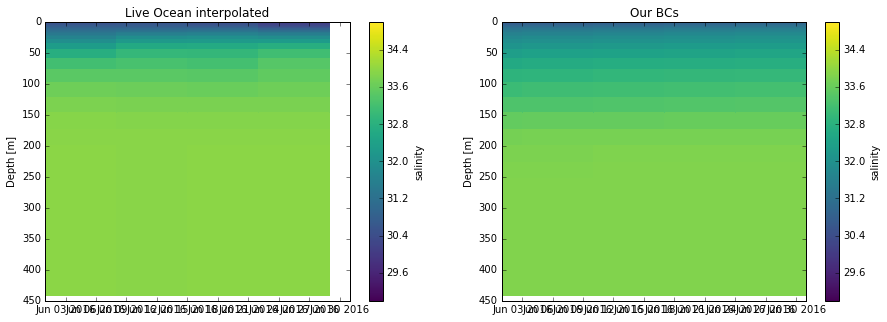

In [23]:
fig,axs = plt.subplots(1,2,figsize=(15,5))
vmin=29
vmax=35
j=0
i=40
#Live Ocean
ax=axs[0]
mesh=ax.pcolormesh(weekly.ocean_time.values[:],depBC,filled[:,:,j,i].T,vmin=vmin,vmax=vmax,cmap='viridis')
cbar = plt.colorbar(mesh,ax=ax)
cbar.set_label('salinity')
ax.set_title('Live Ocean interpolated')
#Our BCs
ax=axs[1]
mesh=ax.pcolormesh(dates,depBC, salBC[:,:,j,i].T, vmin=vmin, vmax=vmax, cmap='viridis')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('salinity')
ax.set_title('Our BCs')
#limits
for ax in axs:
    ax.set_xlim(datetime.datetime(2016,6,1), datetime.datetime(2016,7,1))
    ax.set_ylabel('Depth [m]')
    ax.set_ylim(450,0)